# NAIRU Model

Modelling the non-accelerating inflation rate of unemployment for the Australian economy.

## Acknowledgements

This work has drawn on ideas and approaches in the following:

https://www.rba.gov.au/publications/bulletin/2017/jun/pdf/bu-0617-2-estimating-the-nairu-and-the-unemployment-gap.pdf

https://treasury.gov.au/sites/default/files/2021-04/p2021-164397_estimatingthenairuinaustralia.pdf

https://www.rba.gov.au/education/resources/explainers/pdf/nairu.pdf?v=2024-05-09-14-09-00

https://github.com/MacroDave/NAIRU

https://gross.substack.com/p/navigating-the-nairu?utm_source=publication-search

https://www.rbnz.govt.nz/-/media/project/sites/rbnz/files/publications/analytical-notes/2018/an2018-04.pdf

https://cmr.uni-koeln.de/fileadmin/wiso_fak/cmr/pdf/Berger_Publication_list/nairu.pdf

## Python set-up

In [1]:
# Analtic imports
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import statsmodels.api as sm  # for OLS

In [2]:
# local imports
from abs_data_capture import (
    get_abs_series, 
)
from rba_data_capture import (
    get_data,
)
import plotting

In [3]:
# Plotting set-up
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/NAIRU/"
plotting.set_chart_dir(CHART_DIR)
plotting.clear_chart_dir(CHART_DIR)

# display charts in this notebook
SHOW = True

## Data capture

In [4]:
def monthly_to_quarterly(data: pd.Series) -> pd.Series:
    """Convert monthly data to quarterly data by taking the mean of 
    the three months in each quarter. Ignore quarters with less than 
    three months data. Drop NA items."""

    return (
        data
        .groupby(pd.PeriodIndex(data.index, freq="Q"))
        .agg(['mean', 'count'])
        .apply(lambda x: x['mean'] if x['count'] == 3 else np.nan, axis=1)
        .dropna()
    )


#### Unemployment rate

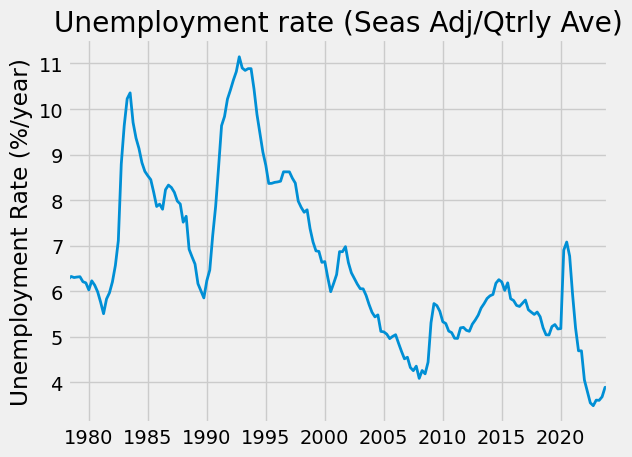

In [5]:

def get_u() -> tuple[pd.Series, pd.Series, pd.Series]:
    """Get the unemployment related data from the ABS and
    calculate the UE rate, and the change in the UE rate
    as a proportion of the UE rate."""

    # get the unemployment rate
    lfs_meta, lfs = get_abs_series(cat_id="6202.0", series_ids=["A84423043C", "A84423047L"])
    employed = lfs["A84423043C"]  # employed persons, thousands, seasonally adjusted
    labour_force = lfs["A84423047L"]  # labour force, thousands, seasonally adjusted
    ue_rate_m = ((1 - employed / labour_force) * 100).dropna()
    ue_rate_q = monthly_to_quarterly(ue_rate_m)

    # calculate the change in the UE rate as a proportion of the UE rate
    #delta_U_1_over_U = (ue_rate_q.diff(periods=1) / ue_rate_q).dropna()
    delta_U_1_over_U = (ue_rate_q.pct_change() / ue_rate_q).dropna()

    return ue_rate_q, delta_U_1_over_U


U, ΔU_1_over_U = get_u()
if SHOW:
    ax = U.plot(
        title="Unemployment rate (Seas Adj/Qtrly Ave)", xlabel="", lw=2
    )
    ax.set_ylabel("Unemployment Rate (%/year)")
    plt.tight_layout()
    plt.savefig(CHART_DIR + "UE_RATE.png")
    plt.show()

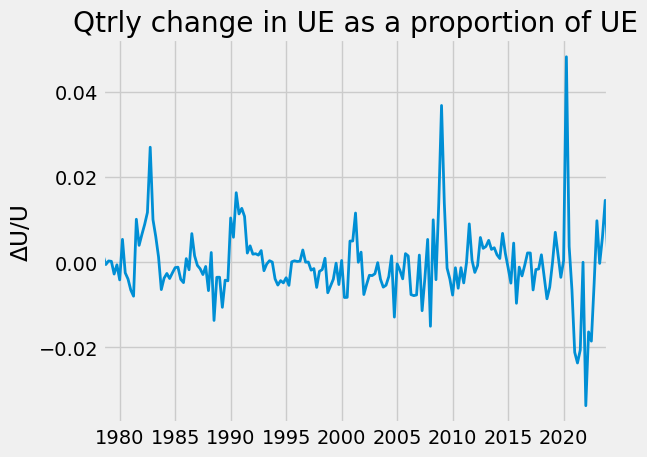

In [6]:
if SHOW:
    ax = ΔU_1_over_U.plot(
        title="Qtrly change in UE as a proportion of UE", xlabel="", lw=2
    )
    ax.set_ylabel("ΔU/U")
    plt.tight_layout()
    plt.savefig(CHART_DIR + "UE_RATE_CHANGE.png")
    plt.show()

#### Inflation

In [7]:
def get_ρ(measure="TM")-> tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    """Get the QonQ core inflation rate from the ABS, plus lagged rates.
    Arguments: Can choose between the trimmed mean (measure="TM") and the 
    weighted median (measure="WM").
    Returns: A tuple of four series - the core inflation rate, and that 
    rate lagged by 1, 2 and 3 quarters."""

    # core inflation
    cpi_meta, cpi = get_abs_series(cat_id="6401.0", series_ids=["A3604510W", "A3604504A"])
    trimmed_mean = cpi["A3604510W"]  # preferred measure of core inflation
    weighted_median = cpi["A3604504A"]  # alternative measure of core inflation
    core = trimmed_mean if measure == "TM" else weighted_median
    delta_rho = core.dropna().sort_index()
 
    # lagged core inflation
    delta_rho_1 = delta_rho.shift(periods=1).dropna()
    delta_rho_2 = delta_rho.shift(periods=2).dropna()
    delta_rho_3 = delta_rho.shift(periods=3).dropna()

    return delta_rho, delta_rho_1, delta_rho_2, delta_rho_3


Δρ, Δρ_1, Δρ_2, Δρ_3 = get_ρ()

Core inflation data from/to: 1982Q2 2024Q1


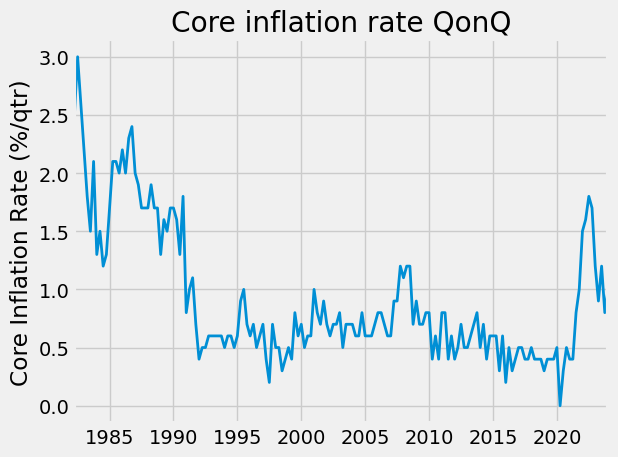

In [8]:
print("Core inflation data from/to:", Δρ.index[0], Δρ.index[-1])
if SHOW:
    ax = Δρ.plot(title="Core inflation rate QonQ", xlabel="", lw=2)
    ax.set_ylabel("Core Inflation Rate (%/qtr)")
    plt.tight_layout()
    plt.savefig(CHART_DIR + "CORE_INFLATION.png")
    plt.show()


#### Inflation expectations (mix of real and synthetic data)

I have serious dobts about the generated synthetic data

In [9]:
def get_πe(trimmed_mean: pd.Series)-> pd.Series:
    """Get inflation expectations from the RBA data."""

    # inflation expectations from survey
    g3_meta, g3 = get_data("Inflation Expectations – G3")
    expectations = g3["GBUSEXP"].dropna()  # Business inflation expectations – 3-months ahead, per cent per year
    expectations = expectations.to_period(freq="Q")

    # Australian Government 10-year bond yield
    # 
    bond_yields = pd.read_excel(
        "./NAIRU_INPUTS/RBA_bonds.xls", index_col=0, parse_dates=True, skiprows=10
    )
    bond_yield = monthly_to_quarterly(bond_yields["FCMYGBAG10"])
    # There is a missing value in Q2 2013, so we will interpolate it
    new_by_index = pd.period_range(start=bond_yield.index[0], end=bond_yield.index[-1], freq="Q")
    bond_yield = bond_yield.reindex(new_by_index)
    print("Missing values in bond yield: ", bond_yield[bond_yield.isna()].index)
    bond_yield = bond_yield.interpolate(method="linear", limit_area="inside")
    Δbond_yield = bond_yield.pct_change(periods=1).dropna()

    # let's construct a synthetic inflation expectations series - back as far as the trimmed mean
    # using bond yields, trimmed_mean, and survey data
    X = pd.DataFrame({"annual_bond_yield": bond_yield.loc[expectations.index]})
    X['Δbond_yield'] = Δbond_yield
    X['trimmed'] = trimmed_mean.loc[expectations.index]
    #X['time'] = np.arange(1.0, len(X)/10 + 1.0, 0.1)[::-1] 
    #X['const'] = 1.0
    X = X.astype(float)
    y = expectations.astype(float)
    model = sm.OLS(y, X)
    fit = model.fit()
    p = fit.summary()
    print(p)
    ypred = fit.predict(X)
    # And extrapolate
    last_index = X.index[0] - 1
    first_index = trimmed_mean.index[0]
    index_range = pd.period_range(start=first_index, end=last_index, freq="Q")
    X_out = pd.DataFrame({"annual_bond_yield": bond_yield.loc[index_range]})
    X_out['Δbond_yield'] = Δbond_yield.loc[index_range]
    X_out['trimmed'] = trimmed_mean.loc[index_range]
    #starting = X.time.iloc[0] + 0.1
    #X_out['time'] = np.arange(start=starting, stop=len(X_out)/10 + starting -0.05, step=0.1)[::-1]
    #X_out['const'] = 1.0
    oos = fit.predict(X_out) + 2.5  # KLUDGE: add 2.5% because oos is different to in-smaple 
    i_expect = pd.concat([oos, y]).sort_index()
    Δρe = i_expect.dropna() / 4  # roughly convert to quarterly
    return Δρe


Δρe = get_πe(Δρ)

Missing values in bond yield:  PeriodIndex(['2013Q2'], dtype='period[Q-DEC]')
                                 OLS Regression Results                                
Dep. Variable:                GBUSEXP   R-squared (uncentered):                   0.904
Model:                            OLS   Adj. R-squared (uncentered):              0.902
Method:                 Least Squares   F-statistic:                              425.7
Date:                Thu, 23 May 2024   Prob (F-statistic):                    6.63e-69
Time:                        18:50:00   Log-Likelihood:                         -139.37
No. Observations:                 139   AIC:                                      284.7
Df Residuals:                     136   BIC:                                      293.5
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err   

In [10]:
pie = (
    pd.read_csv("./NAIRU_INPUTS/PIE_RBAQ.CSV", index_col=0, parse_dates=True)
    .to_period(freq="Q")
    .pipe(lambda x: x[x.columns[0]])
    .dropna()
)

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_79177/2434843306.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv("./NAIRU_INPUTS/PIE_RBAQ.CSV", index_col=0, parse_dates=True)


<Axes: title={'center': 'Core inflation QonQ vs. expectations'}>

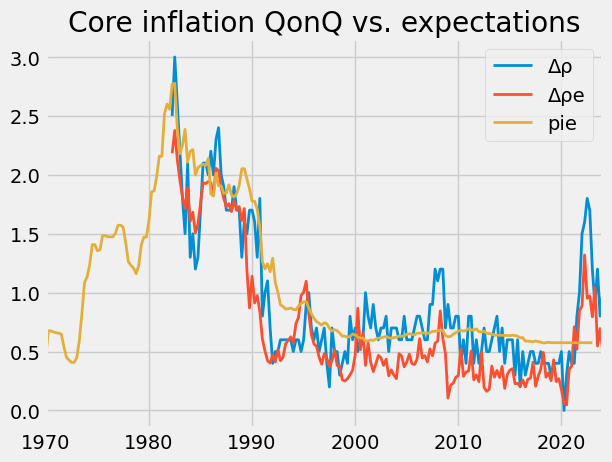

In [11]:
pd.DataFrame({"Δρ": Δρ, "Δρe": Δρe, "pie": pie}).plot(title="Core inflation QonQ vs. expectations", xlabel="", lw=2)

#### Import prices

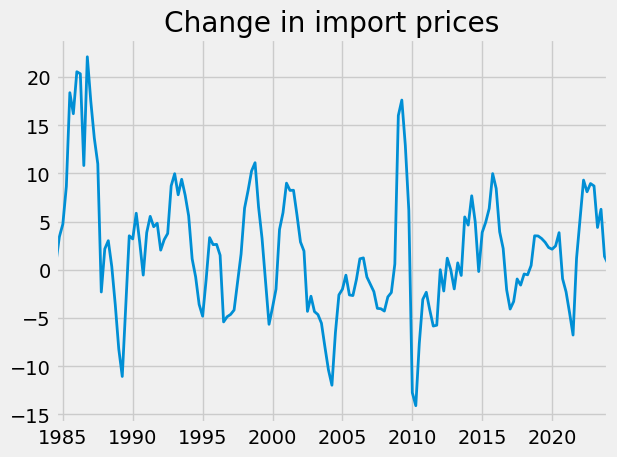

In [12]:
def get_import_pricing() -> tuple[pd.Series, pd.Series]:
    """Get the import pricing data from the ABS and calculate the
    change in import prices as a proportion of the import prices."""

    # Import Price Index by Balance of Payments, index, original
    trade_meta, trade = get_abs_series(cat_id="6457.0", series_ids=["A2298279F"])
    log_import_prices = trade["A2298279F"].apply(np.log)
    delta4_log_import_prices = log_import_prices.diff(periods=4).dropna() * 100
    Δ4ρm_1 = delta4_log_import_prices.shift(periods=1).dropna()
    Δ4ρm_2 = delta4_log_import_prices.shift(periods=2).dropna()

    return Δ4ρm_1, Δ4ρm_2  


Δ4ρm_1, Δ4ρm_2 = get_import_pricing()
if SHOW:
    Δ4ρm_1.plot(title="Change in import prices", xlabel="", lw=2)
    plt.tight_layout()
    plt.savefig(CHART_DIR + "IMPORT_PRICES.png")
    plt.show()

#### Unit labour costs

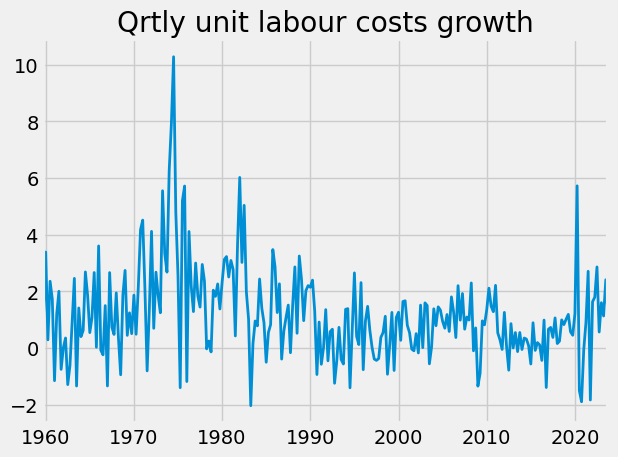

In [13]:

def get_ulc() -> pd.Series:
    """Quarterly unit labour costs growth."""

    nat_accounts_meta, nat_accounts = (
        get_abs_series(cat_id="5206.0", series_ids=["A2304402X", "A2302915V"])
    )
    ulc = nat_accounts["A2302915V"]/nat_accounts["A2304402X"]
    log_ulc = ulc.apply(np.log)
    periods = 1 # average over N quarters
    delta_ulc = (log_ulc.diff(periods=periods)).dropna() * 100 / periods
    return delta_ulc


Δulc = get_ulc()
if SHOW:
    Δulc.plot(title="Qrtly unit labour costs growth", xlabel="", lw=2)
    plt.tight_layout()
    plt.savefig(CHART_DIR + "ULC.png")
    plt.show()


## Data wrangling

Make sure all the vectors are the same length, with no missing data, and in the correct vector format

In [14]:
def build_obs() -> dict[str, np.ndarray]:
    """Here, we standardise the length of all observations
    and place them into the obs dictionary, which is returned.
    Beacuse the PeriodIndex data has been removed from the
    "observations matrix", we also return the index separately."""

    start = pd.Period("1986Q1", freq="Q")

    observed = pd.DataFrame({
        "Δρ": Δρ,                       # trimmed mean inflation
        "Δρ_1": Δρ_1,                   # lagged trimmed mean inflation
        "Δρ_2": Δρ_2,
        "Δρ_3": Δρ_3, 
        "Δρe": Δρe,                     # inflation expectations
        "U": U,                         # unemployment rate
        "ΔU_1_over_U": ΔU_1_over_U,     # change in UE rate as a proportion of UE rate
        "Δ4ρm_1": Δ4ρm_1,               # annual change in import prices,
        "Δ4ρm_2": Δ4ρm_2,               # annual change in import prices, lagged 1 period
        "Δulc": Δulc,                   # unit labour costs growth
    })
    observed = observed.dropna(how="any")  # Note ulc comes from Nat Accounts, which is delayed data
    print(f"Number of months: {len(observed)}; concluding: {observed.index[-1]}")

    return {x: y.to_numpy() for x, y in observed.items()}, observed.index


obs, obs_index = build_obs()

Number of months: 157; concluding: 2023Q4


## Bayesian model

#### The PyMC model

In [15]:
def inflation_equation(
    input: dict[str, np.ndarray], 
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
) -> None:
    """Inflation likelihood equation."""
    
    with model:
        alpha_inf = pm.Normal("alpha_inf", mu=0.005, sigma=0.002)  # inflation expectations
        beta1_inf = pm.Normal("beta1_inf", mu=0.5, sigma=0.1)  # lagged inflation
        beta2_inf = pm.Normal("beta2_inf", mu=0.5, sigma=0.1)
        beta3_inf = pm.Normal("beta3_inf", mu=0.5, sigma=0.1)
        gamma_inf = pm.Normal("gamma_inf", mu=0.6, sigma=0.1)  # unemployment gap
        delta_inf = pm.Normal("delta_inf", mu=0.5, sigma=0.1)  # import prices
        lambda_inf = pm.Normal("lambda_inf", mu=0.5, sigma=0.1)  # UE rate change
        observed_price_inflation = pm.Normal(
            "observed_price_inflation",
            mu = 
            alpha_inf * (input["Δ4ρm_1"] - input["Δ4ρm_2"])
            + beta1_inf * input["Δρ_1"] 
            + beta2_inf * input["Δρ_2"] 
            + beta3_inf * input["Δρ_3"]
            + gamma_inf * (input["U"] - nairu)/input["U"] 
            + delta_inf * input["Δρe"]
            + lambda_inf * input["ΔU_1_over_U"],
            sigma=0.5,
            observed=input["Δρ"],
        )

def wage_growth_equation(
    input: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk
) -> None:
    """Wage growth likelihood equation."""

    with model:
        # priors
        #delta_lab = pm.Normal("delta_lab", mu=-0.45, sigma=0.21)
        omega_lab = pm.Normal("omega_lab", mu=0.2, sigma=0.1)
        gamma_lab = pm.Normal("gamma_lab", mu=-2.6, sigma=0.1)
        lambda_lab = pm.Normal("lambda_lab", mu=-5.6, sigma=2.0)
        const_lab = pm.Normal("const_lab", mu=0.0, sigma=10)

        # likelihood
        observed_wage_growth = pm.Normal(
            "observed_wage_growth",
            mu = 0
            #+ delta_lab * input["Δρe"] # inflation expectations
            + omega_lab * (input["Δρ_1"] +  input["Δρ_2"])  
            + gamma_lab * ((input["U"] - nairu)/input["U"])
            + lambda_lab * input["ΔU_1_over_U"]
            + const_lab
            ,
            sigma=0.5,
            observed=input["Δulc"],
        )

def nairu_equation(input: dict[str, np.ndarray], model) -> pm.GaussianRandomWalk:
    """Gaussian random walk for the NAIRU."""

    with model:
        nairu_start = pm.Normal.dist(mu=7, sigma=2)
        #nairu_innovation = pm.Normal("nairu_innovation", mu=0.15, sigma=0.05)
        nairu_innovation = 0.15  # fixed innovation for now
        nairu = pm.GaussianRandomWalk(
            "nairu",
            mu=0,  # no drift in this model
            sigma=nairu_innovation,
            init_dist=nairu_start,
            steps=len(input["U"])-1,
        )
    return nairu


def define_model(input: dict[str, np.ndarray]) -> pm.Model:
    """Define the model for the NAIRU estimation."""

    model = pm.Model()

    nairu = nairu_equation(input, model)
    inflation_equation(input, model, nairu)
    wage_growth_equation(input, model, nairu)        

    return model


model = define_model(input=obs)

#### Generate a map of the model

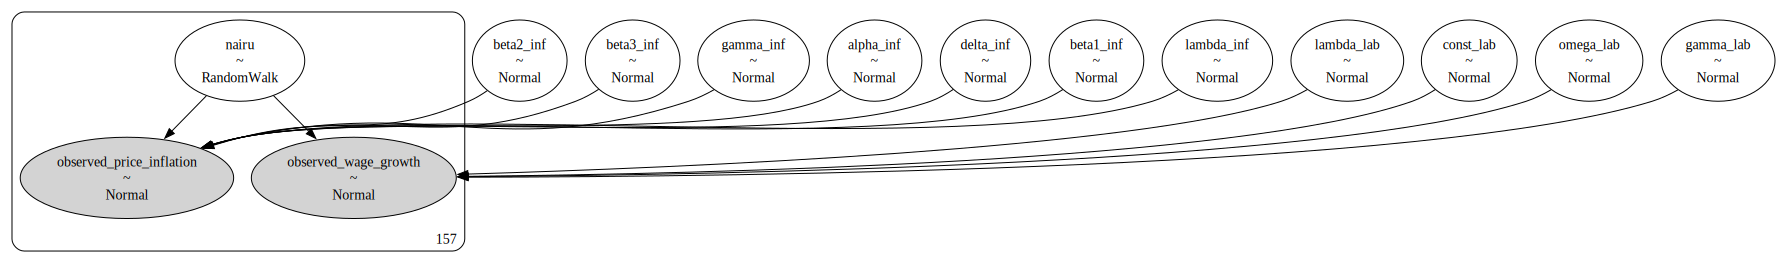

In [16]:
def produce_model_map(m: pm.Model) -> None:
    """Produce a map of the model."""
    
    gv = pm.model_to_graphviz(m)
    gv.render(
        format="png",
        filename=("./NAIRU_INPUTS/nairu model"),
    )
    display(gv)


produce_model_map(model)

#### Fit the model to the data

In [17]:
N_CORES: int = 8
SAMPLES: int = 100_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
TUNE: int = 5_000  # per chain

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
}

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

  0%|          | 0/17500 [00:00<?, ?it/s]

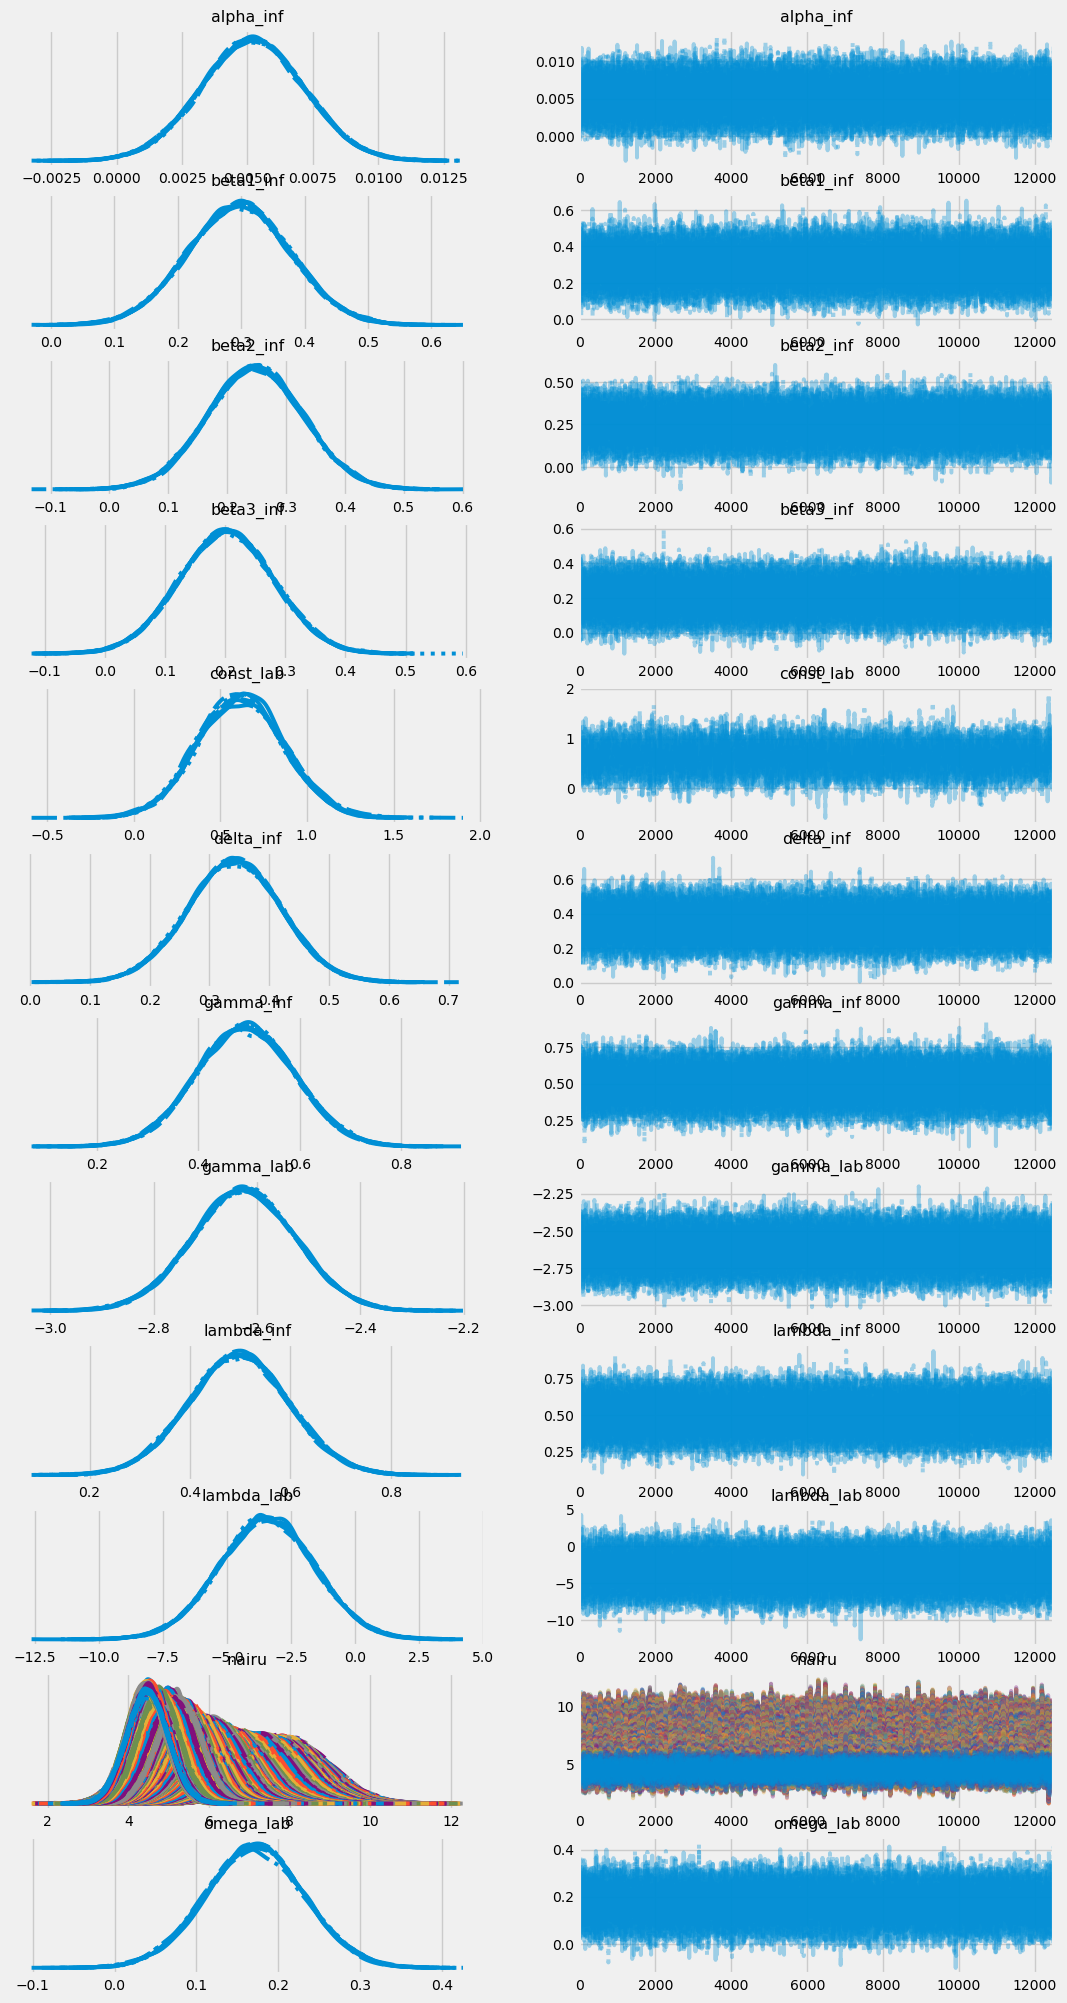

In [18]:
def fit_the_model(model: pm.Model) -> az.InferenceData:
    """Fit the data to the model."""
    
    with model:
        idata = pm.sample(
            **SAMPLE_ARGS,
            progressbar=True,
            return_inferencedata=True,
        )
        az.plot_trace(idata)
    return idata


trace = fit_the_model(model)

## Check diagnostics

In [19]:
def check_trace(trace: az.InferenceData) -> None:
    """Check the trace for potential problems."""

    def warn(w: bool) -> str:
        return '--- THERE BE DRAGONS ---> ' if w else ''
    
    summary = az.summary(trace)

    max_r_hat = 1.01
    statistic = summary.r_hat.max()
    print(f"{warn(statistic > max_r_hat)}Maximum R-hat convergence diagnostic: {statistic}")

    min_ess = 400
    statistic = summary[["ess_tail", "ess_bulk"]].min().min()
    print(f"{warn(statistic < min_ess)}Minimum effective sample size (ESS) estimate: {statistic}")

    try:
        diverging_count = int(np.sum(trace.sample_stats.diverging))
    except (ValueError, AttributeError):  # No sample_stats, or no .diverging
        diverging_count = 0
    print(f"{warn(diverging_count > 0)}Divergent transitions in HMC sampling: {diverging_count}")  


check_trace(trace)

Maximum R-hat convergence diagnostic: 1.0
Minimum effective sample size (ESS) estimate: 4728.0
Divergent transitions in HMC sampling: 0


## Results

In [20]:
def get_var(var_name: str, trace: az.InferenceData) -> pd.DataFrame:
    """Extract the chains/draws for a specified var_name."""

    return (
        az.extract(trace, var_names=var_name)
        .transpose("sample", ...)
        .to_dataframe()[var_name]
        .unstack(level=2)
        .T
    )

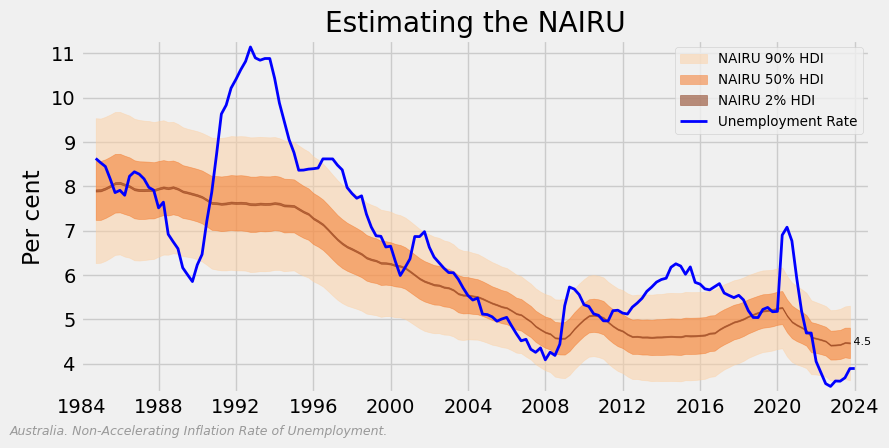

In [21]:
def plot_nairu(
    trace: az.InferenceData,
    obs: dict[str, np.ndarray],
    obs_index: pd.PeriodIndex,
) -> None:
    """Plot the NAIRU."""

    nairu = get_var("nairu", trace)
    nairu.index = obs_index.to_timestamp()
    PERCENTS = [5, 25, 49]
    _COLORS = [(p - min(PERCENTS)) / (max(PERCENTS) - min(PERCENTS)) for p in PERCENTS]
    MIN_COLOR = 0.25
    COLOR_FRACS = [c * (1.0 - MIN_COLOR) + MIN_COLOR for c in _COLORS]
    palette = "Oranges"
    _, ax = plt.subplots()
    cmap = plt.get_cmap(palette)

    for i, p in enumerate(PERCENTS):
        quants = p, 100 - p
        label = f"NAIRU {quants[1] - quants[0]}% HDI"
        lower, upper = [nairu.quantile(q=q / 100.0, axis=1) for q in quants]
        color = COLOR_FRACS[i]
        ax.fill_between(
            nairu.index,
            upper,
            lower,
            color=cmap(color),
            alpha=0.5,
            label=label,
            zorder=i + 1,
        )
    Uplot = U[U.index >= obs_index[0]]
    ax.plot(
        Uplot.index.to_timestamp(),
        Uplot,
        color="blue",
        lw=2,
        label="Unemployment Rate",
        zorder=10,
    )
    latest = round(nairu.iloc[-1].quantile(0.5), 1)
    ax.text(nairu.index[-1], latest, f" {latest}", va="center", ha="left", color="black", fontsize=8)
    plotting.finalise_plot(
        ax,
        title="Estimating the NAIRU",
        ylabel="Per cent",
        legend={"loc": "upper right", "fontsize": "x-small"},
        lfooter="Australia. Non-Accelerating Inflation Rate of Unemployment.",
        show=True,
    )


plot_nairu(trace, obs, obs_index)

In [22]:
def print_parameter_summary() -> None:
    """Print the summary results of the model,
       useful for non-vector free variables in the model.
       Also indicates where parameters may be indistinguisable from zero,
       (ie. they are not significant within the model)."""

    # Calculate the 96% HDI for the model parameters
    q = [0.05, 0.25, 0.5, 0.75, 0.95]  
    print(f"{(q[-1] - q[0]) * 100:0.0f}% HDI for the model parameters:")
    results = {str(name): (
        az.extract(trace, var_names=str(name))
        .to_dataframe()[str(name)]
        .quantile(q)) for name in model.free_RVs
        if str(name) not in ["nairu"]
    }

    # Identify when the HDI includes zero, 
    # which is a sign of a problematic parameter
    df = pd.DataFrame(results).T.sort_index()
    df['Problematic'] = np.sign(df.T).nunique() != 1
    df['Problematic'] = df['Problematic'].replace({True: '***', False: ''})

    # display results
    display(df)


print_parameter_summary()

90% HDI for the model parameters:


,0.05,0.25,0.5,0.75,0.95,Problematic
alpha_inf,0.001949,0.003869,0.005194,0.006517,0.008401,
beta1_inf,0.163662,0.242138,0.296909,0.350974,0.430038,
beta2_inf,0.114854,0.193076,0.247550,0.302197,0.381032,
beta3_inf,0.073463,0.149325,0.202188,0.254999,0.331266,
const_lab,0.212360,0.447138,0.616440,0.785490,1.036759,
delta_inf,0.211433,0.288759,0.341512,0.394418,0.469343,
gamma_inf,0.336097,0.428056,0.492638,0.557768,0.650190,
gamma_lab,-2.789550,-2.692792,-2.626090,-2.559340,-2.462942,
lambda_inf,0.332617,0.429819,0.496770,0.563758,0.661926,
lambda_lab,-6.484717,-4.683571,-3.443487,-2.190242,-0.387965,
